In [47]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [48]:
# Read the dataset
df = pd.read_csv('../Dataset/BID-Historical-Data_Group-9.csv',index_col='Date', parse_dates=True)
df.dropna() #Drop missing value
df = df.sort_values(by='Date', ascending=True)
df =df.reset_index(drop=True) #Reset the index
print(df)

          Price       Open       High        Low     Vol. Change %
0     25,141.50  24,950.20  25,332.90  24,950.20    1.45M    1.08%
1     25,715.50  25,332.90  25,830.30  25,256.30    1.15M    2.28%
2     26,480.90  25,409.40  27,016.60  25,409.40    5.30M    2.98%
3     26,595.70  26,480.90  26,710.50  26,327.80    2.01M    0.43%
4     26,710.50  26,787.00  26,978.30  26,557.40    2.14M    0.43%
...         ...        ...        ...        ...      ...      ...
1308  48,900.00  49,400.00  49,400.00  48,550.00  763.20K   -0.61%
1309  49,100.00  49,000.00  49,200.00  48,600.00    1.23M    0.41%
1310  48,600.00  49,450.00  49,450.00  48,600.00    1.39M   -1.02%
1311  47,700.00  48,400.00  48,500.00  47,400.00    2.09M   -1.85%
1312  47,100.00  47,700.00  48,300.00  47,100.00    1.97M   -1.26%

[1313 rows x 6 columns]


In [49]:
print(df.dtypes)

Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [50]:
# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'], df['Open'], df['High'], df['Low'] = [df[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
df['Change %'] = df['Change %'].apply(convert_change_to_number)
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

print(df)
df.describe()

        Price     Open     High      Low     Vol.  Change %
0     25141.5  24950.2  25332.9  24950.2  1450000    0.0108
1     25715.5  25332.9  25830.3  25256.3  1150000    0.0228
2     26480.9  25409.4  27016.6  25409.4  5300000    0.0298
3     26595.7  26480.9  26710.5  26327.8  2009999    0.0043
4     26710.5  26787.0  26978.3  26557.4  2140000    0.0043
...       ...      ...      ...      ...      ...       ...
1308  48900.0  49400.0  49400.0  48550.0   763200   -0.0061
1309  49100.0  49000.0  49200.0  48600.0  1230000    0.0041
1310  48600.0  49450.0  49450.0  48600.0  1390000   -0.0102
1311  47700.0  48400.0  48500.0  47400.0  2089999   -0.0185
1312  47100.0  47700.0  48300.0  47100.0  1970000   -0.0126

[1313 rows x 6 columns]


,Price,Open,High,Low,Vol.,Change %
count,1313.000000,1313.000000,1313.000000,1313.000000,1.313000e+03,1313.000000
mean,35290.396420,35290.707388,35805.167479,34820.149429,2.018955e+06,0.000722
std,6519.054229,6544.786381,6627.970793,6453.353467,1.446782e+06,0.021709
min,23419.500000,23419.500000,24108.300000,22958.500000,1.838000e+05,-0.099300
25%,30970.000000,30970.000000,31325.000000,30613.700000,1.090000e+06,-0.009200
50%,34120.000000,34110.600000,34625.000000,33635.800000,1.650000e+06,0.000000
75%,39356.000000,39400.000000,39846.500000,38912.000000,2.460000e+06,0.012000
max,54400.000000,54400.000000,56700.000000,53500.000000,1.638000e+07,0.070000


In [51]:
df1=df.reset_index()['Price']
df1

0       25141.5
1       25715.5
2       26480.9
3       26595.7
4       26710.5
         ...   
1308    48900.0
1309    49100.0
1310    48600.0
1311    47700.0
1312    47100.0
Name: Price, Length: 1313, dtype: float64

In [52]:
# 3. Split into train and test sets
train_size = int(0.9 * len(df))
test_size = len(df)-train_size

train_data = df[:train_size]
test_data = df[train_size:]
train_data

,Price,Open,High,Low,Vol.,Change %
0,25141.5,24950.2,25332.9,24950.2,1450000,0.0108
1,25715.5,25332.9,25830.3,25256.3,1150000,0.0228
2,26480.9,25409.4,27016.6,25409.4,5300000,0.0298
3,26595.7,26480.9,26710.5,26327.8,2009999,0.0043
4,26710.5,26787.0,26978.3,26557.4,2140000,0.0043
...,...,...,...,...,...,...
1176,38025.0,38158.0,38291.0,37803.0,852730,-0.0012
1177,37448.0,37625.0,38069.0,37359.0,707020,-0.0152
1178,37359.0,37448.0,37892.0,37226.0,534040,-0.0024
1179,38158.0,37492.0,38557.0,37492.0,1770000,0.0214


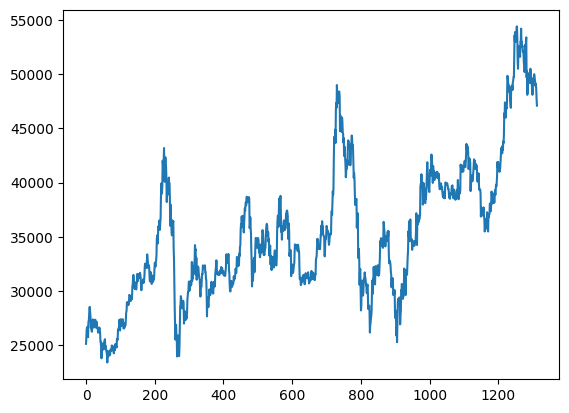

In [53]:
plt.plot(df1)

In [54]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [55]:
# df1.shape
print(df1)

[[0.05558335]
 [0.07411113]
 [0.098817  ]
 ...
 [0.81278546]
 [0.78373493]
 [0.76436791]]


In [56]:
# 4. split the data into train and test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [57]:
#Training process
# a. convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

# b. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [58]:
print(X_train)

[[0.05558335 0.07411113 0.098817   ... 0.12722519 0.11487226 0.09511144]
 [0.07411113 0.098817   0.10252255 ... 0.11487226 0.09511144 0.11363922]
 [0.098817   0.10252255 0.10622811 ... 0.09511144 0.11363922 0.12846145]
 ...
 [0.48719356 0.5029454  0.5129517  ... 0.44135827 0.47286196 0.47144171]
 [0.5029454  0.5129517  0.5129517  ... 0.47286196 0.47144171 0.45281709]
 [0.5129517  0.5129517  0.5129517  ... 0.47144171 0.45281709 0.44994432]]


In [59]:
# 8. Define GRU Model
model = xgb.XGBRegressor(
                        objective='reg:squarederror',
                        n_estimators=1000,
                        learning_rate=0.01,
                        max_depth=6,
                        subsample=0.8,
                        colsample_bytree=0.8)

In [60]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [61]:
# 7. Dự báo dữ liệu test, val
y_pred=model.predict(X_test)
y_pred

array([0.6644389 , 0.6648766 , 0.66525644, 0.66500753, 0.6639964 ,
       0.6653193 , 0.66605896, 0.66562015, 0.6651474 , 0.66439354,
       0.66414267, 0.6644114 , 0.664705  , 0.66495794, 0.66438836,
       0.6631973 , 0.6636769 , 0.66361845, 0.66347855, 0.6632885 ,
       0.66334677, 0.66339195, 0.6634089 , 0.6632478 , 0.6637282 ,
       0.66393745, 0.662728  , 0.66290283, 0.66299325, 0.6630259 ,
       0.6628907 ], dtype=float32)

In [62]:
# 12. inverse transform the scaled ytest data back to its original scale.
y_pred_ = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_ = scaler.inverse_transform(y_test.reshape(-1,1))
# 12. Đánh giá độ chính xác thuật toán 
test_rmse = np.sqrt(np.mean((y_pred_ - y_test_)**2))
print('Testing RMSE:', test_rmse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test_, y_pred_)
print('Testing MAE:', test_mae)

from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test_, y_pred_)
print('Testing MAPE:', test_mape)  

Testing RMSE: 5515.662426495009
Testing MAE: 5428.833921370968
Testing MAPE: 0.10951099421085393


In [63]:
#Dự đoán 30 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 30
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.6194495]
2 day output [0.5719881]
3 day output [0.5492889]
4 day output [0.5256403]
5 day output [0.49358502]
6 day output [0.45624083]
7 day output [0.44737124]
8 day output [0.44430798]
9 day output [0.427298]
10 day output [0.37800068]
11 day output [0.39118612]
12 day output [0.39081243]
13 day output [0.38654855]
14 day output [0.37645125]
15 day output [0.37122458]
16 day output [0.35439345]
17 day output [0.34472963]
18 day output [0.32532546]
19 day output [0.31509283]
20 day output [0.3156493]
21 day output [0.31550953]
22 day output [0.3167417]
23 day output [0.31770006]
24 day output [0.31950852]
25 day output [0.32188776]
26 day output [0.3244802]
27 day output [0.32032374]
28 day output [0.32442632]
29 day output [0.32259235]
Output of predicted next days:  [0.6625308990478516, 0.6194494962692261, 0.5719881057739258, 0.5492889285087585, 0.5256403088569641, 0.4935850203037262, 0.45624083280563354, 0.447371244430542, 0.44430798292160034, 0.42729800939559937, 

In [64]:
y_pred = y_pred.reshape(-1,1)
y_pred = scaler.inverse_transform(y_pred)

print("Test data prediction:", y_pred.shape)

Test data prediction: (31, 1)


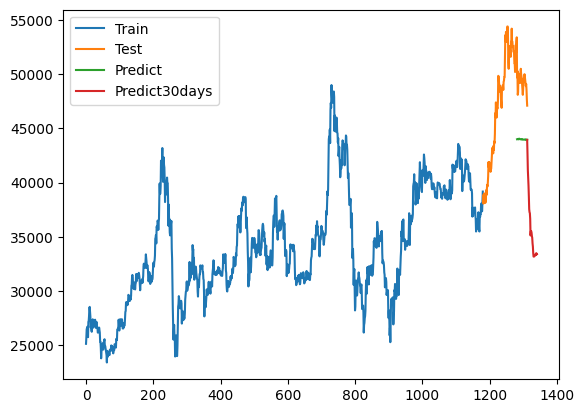

In [65]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [66]:
#Dự đoán 60 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 60
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.6194495]
2 day output [0.5719881]
3 day output [0.5492889]
4 day output [0.5256403]
5 day output [0.49358502]
6 day output [0.45624083]
7 day output [0.44737124]
8 day output [0.44430798]
9 day output [0.427298]
10 day output [0.37800068]
11 day output [0.39118612]
12 day output [0.39081243]
13 day output [0.38654855]
14 day output [0.37645125]
15 day output [0.37122458]
16 day output [0.35439345]
17 day output [0.34472963]
18 day output [0.32532546]
19 day output [0.31509283]
20 day output [0.3156493]
21 day output [0.31550953]
22 day output [0.3167417]
23 day output [0.31770006]
24 day output [0.31950852]
25 day output [0.32188776]
26 day output [0.3244802]
27 day output [0.32032374]
28 day output [0.32442632]
29 day output [0.32259235]
30 day output [0.3215557]
31 day output [0.3215015]
32 day output [0.32111442]
33 day output [0.3212408]
34 day output [0.32145008]
35 day output [0.32205608]
36 day output [0.32269514]
37 day output [0.32195786]
38 day output [0.32256

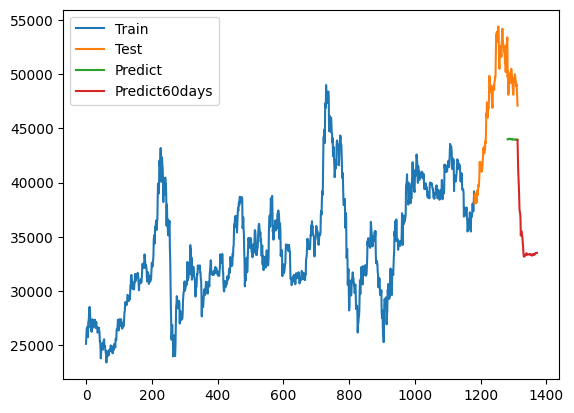

In [67]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))

plt.legend(['Train', 'Test', 'Predict', 'Predict60days'])
plt.show()

In [68]:
#Dự đoán 90 ngày tiếp theo
x_input = test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = time_step
i = 0
pred_days = 90
while(i < pred_days):
    
    if(len(temp_input) > time_step):
        
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1,-1)
        
        yhat = model.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i = i+1
        
    else:
        yhat = model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i = i+1
        
print("Output of predicted next days: ", lst_output)

1 day output [0.6194495]
2 day output [0.5719881]
3 day output [0.5492889]
4 day output [0.5256403]
5 day output [0.49358502]
6 day output [0.45624083]
7 day output [0.44737124]
8 day output [0.44430798]
9 day output [0.427298]
10 day output [0.37800068]
11 day output [0.39118612]
12 day output [0.39081243]
13 day output [0.38654855]
14 day output [0.37645125]
15 day output [0.37122458]
16 day output [0.35439345]
17 day output [0.34472963]
18 day output [0.32532546]
19 day output [0.31509283]
20 day output [0.3156493]
21 day output [0.31550953]
22 day output [0.3167417]
23 day output [0.31770006]
24 day output [0.31950852]
25 day output [0.32188776]
26 day output [0.3244802]
27 day output [0.32032374]
28 day output [0.32442632]
29 day output [0.32259235]
30 day output [0.3215557]
31 day output [0.3215015]
32 day output [0.32111442]
33 day output [0.3212408]
34 day output [0.32145008]
35 day output [0.32205608]
36 day output [0.32269514]
37 day output [0.32195786]
38 day output [0.32256

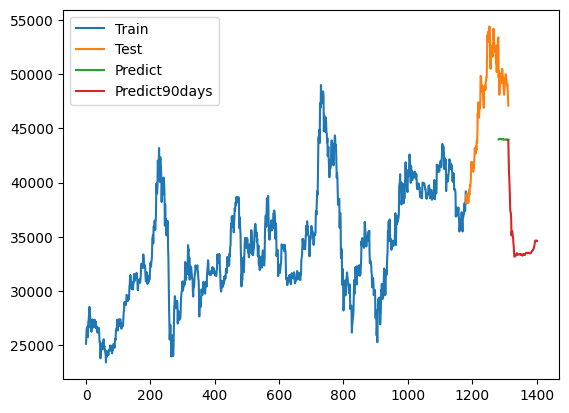

In [69]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index, y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)-1+len(scaler.inverse_transform(np.array(lst_output).reshape(-1,1))), step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(np.array(lst_output).reshape(-1,1)))

plt.legend(['Train', 'Test', 'Predict', 'Predict90days'])
plt.show()